DE MOURA JÚNIOR Paulo Roberto, CHAVEZ BECERRA Cristian Alejandro

# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [ ]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

: 

## Loading data

Let's load the data: take a first look.

In [111]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp)

       Categorie                                text_certifications
0              1  Responsable de chantiers de bûcheronnage manue...
1              1  Responsable de chantiers de bûcheronnage manue...
2              1                                 Travaux forestiers
3              1                                              Forêt
4              1                                              Forêt
...          ...                                                ...
94307         15                                              DANSE
94308         15                                   Manager culturel
94309         15  Diplôme Arts et Techniques du Théâtre délivré ...
94310         15                             Chef de projet musique
94311         15              Création artistique (fiche nationale)

[94312 rows x 2 columns]


In [112]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [113]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [114]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [115]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 1
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 94312


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [116]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(texts_reduced, labels_reduced, test_size=0.2, random_state=42)
train_labels = np.array([int(label) for label in train_labels])
test_labels = np.array([int(label) for label in test_labels])

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [117]:
# Imports
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert text to lower case
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove everything except alphanumeric characters and diacritics
    text = re.sub(r'[^\w\sÀ-ÿ]', ' ', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('french'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = SnowballStemmer('french')
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<div class='alert alert-block alert-info'>
            Code:</div>

In [118]:
train_preproc = [preprocess_text(text) for text in train_texts]

In [119]:
# Look at the data and apply the appropriate pre-processing
print("-------------Raw---------------")
for text in train_texts[:10]:
    print(text)

print("\n-----------------Processed------------------")
for text in train_preproc[:10]:
    print(text)

-------------Raw---------------
Architecte d'interieur/designer
Ingénierie Nucléaire
Métiers du Multimédia et de l’Internet : Développement web et dispositifs interactifs
STAPS : Ingénierie et ergonomie de l'activité physique (IEAP)(fiche nationale)
Programme TEMA (Innovation & Digital Management), visé par le Ministère de l’Enseignement Supérieur et de la Recherche
Ingénieur diplômé de l’Institut National des Sciences Appliquées de Rouen, spécialité Génie Mathématique
Production industrielle option emballage et conditionnement des produits du vivant (Biopack)
MASTER Sciences Humaines et Sociales mention Stratégies du Développement Culturel
Responsable de projets en marketing
Gestion de la production industrielle spécialité Qualité et logistique dans le domaine de la santé

-----------------Processed------------------
['architect', 'interieur', 'design']
['ingénier', 'nucléair']
['méti', 'multimédi', 'internet', 'développ', 'web', 'disposit', 'interact']
['stap', 'ingénier', 'ergonom',

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [120]:
def create_vocabulary(tokenized_set):
    words = set() #unique set of elements

    for tokens in tokenized_set:
        words.update(tokens)

    vocabulary = dict(zip(words, range(len(words))))
    
    return vocabulary

voc = create_vocabulary(train_preproc)
print(voc)
print("Vocabulary size: " + str(len(voc)))

{'largag': 0, 'for': 1, 'fao': 2, 'extrus': 3, 'doublag': 4, 'fiabl': 5, 'jeu': 6, 'écoul': 7, 'région': 8, 'cffp': 9, 'joailler': 10, 'marketing': 11, 'avanc': 12, 'erp': 13, 'qsa': 14, 'mur': 15, 'adhérent': 16, 'sarii': 17, 'genes': 18, 'fuseau': 19, 'epmi': 20, 'prêt': 21, 'dinander': 22, 'méthodolog': 23, 'pac': 24, 'climat': 25, 'maison': 26, 'chebap': 27, 'itech': 28, 'consult': 29, 'interoper': 30, 'bioactif': 31, 'pao': 32, 'titrag': 33, 'stockag': 34, 'deg': 35, 'fib': 36, 'regl': 37, 'envelopp': 38, 'gen': 39, 'exécu': 40, 'lexicolog': 41, 'cart': 42, 'sélect': 43, 'patron': 44, 'informaticien': 45, 'gard': 46, 'chaux': 47, 'universität': 48, 'i': 49, 'bio': 50, 'biosant': 51, 'utilis': 52, 'ere': 53, 'nier': 54, 'strateg': 55, 'afriqu': 56, 'allemand': 57, 'ambianc': 58, 'grignon': 59, 'sdo': 60, 'serrurer': 61, 'cours': 62, 'calm': 63, 'anglais': 64, 'centr': 65, 'eess': 66, 'vendeur': 67, 'poêli': 68, 'acquisit': 69, 'mip': 70, 'gst': 71, 'vinicol': 72, 'continus': 73, 'r

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

The goal here is to keep a good compromise between reducing computational complexity and including more relevant words in the vocabulary that could improve our classification results. One way of assess is to evaluate model performance. Word2Vec representation, for example, will cut words that have less than 5 occurrences by default. The computational complexity here is not a problem since we're using a simple classifier (Logistic Regression), so we decided to not do any further processing in the vocabulary, as we don't have that many words (around 4000) and it won't be a bottleneck for our model.

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

['largag' 'for' 'fao' ... 'cw' 'anthropis' 'littératur']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


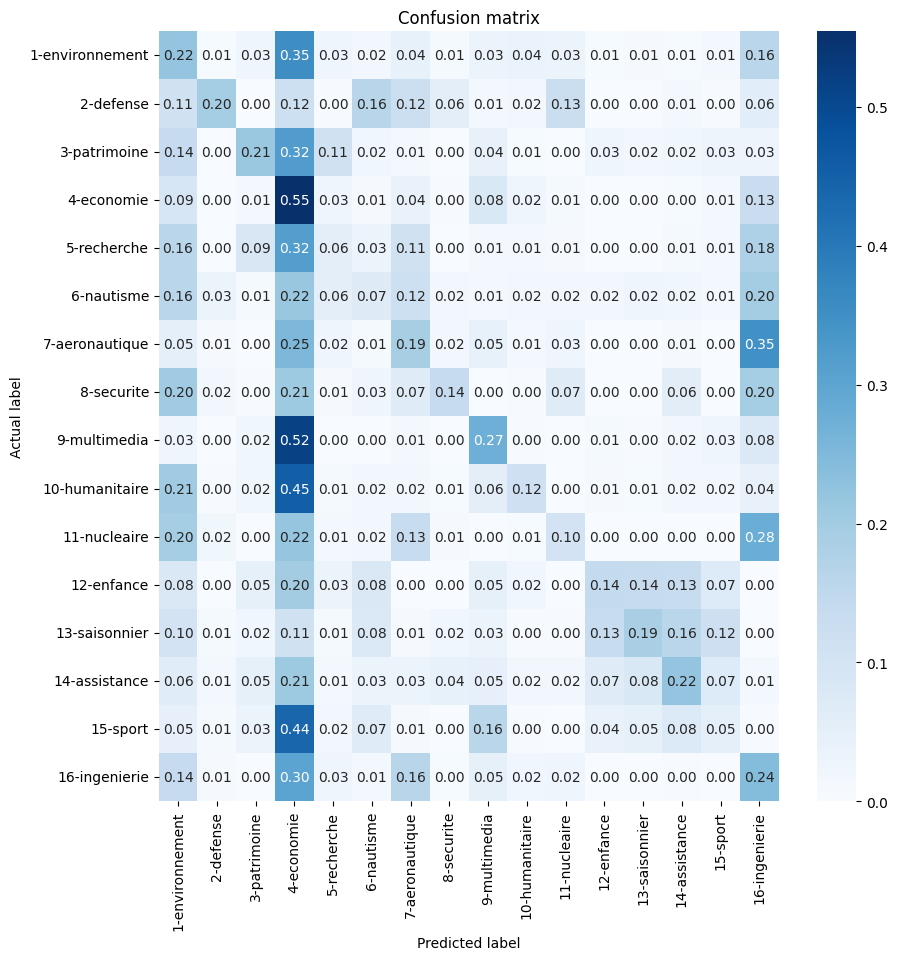

                 precision    recall  f1-score   support

1-environnement      0.223     0.221     0.222      2404
      2-defense      0.273     0.195     0.227       246
   3-patrimoine      0.327     0.213     0.258       794
     4-economie      0.306     0.554     0.394      3864
    5-recherche      0.107     0.058     0.076       975
     6-nautisme      0.162     0.071     0.099      1008
 7-aeronautique      0.212     0.192     0.202      1529
     8-securite      0.223     0.141     0.172       306
   9-multimedia      0.301     0.274     0.287      1398
 10-humanitaire      0.325     0.116     0.171      1302
   11-nucleaire      0.208     0.102     0.137       775
     12-enfance      0.195     0.143     0.165       329
  13-saisonnier      0.210     0.188     0.199       292
  14-assistance      0.284     0.222     0.249       568
       15-sport      0.119     0.051     0.071       767
  16-ingenierie      0.198     0.244     0.218      2306

       accuracy              

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=voc)

corpus = [' '.join(tokens) for tokens in train_preproc]

Bow = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(Bow.toarray())

test_preproc = [preprocess_text(text) for text in test_texts]
test_corpus = [' '.join(tokens) for tokens in test_preproc]
Bow_test = vectorizer.transform(test_corpus)

model = LogisticRegression(max_iter=1000)
model.fit(Bow, train_labels)
pred_labels = model.predict(Bow_test)

# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print classification report
print(classification_report(test_labels, pred_labels, digits=3, target_names=Categories))

Feature names (vocabulary): ['largag' 'for' 'fao' ... 'cw' 'anthropis' 'littératur']


TF-IDF matrix (training data):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


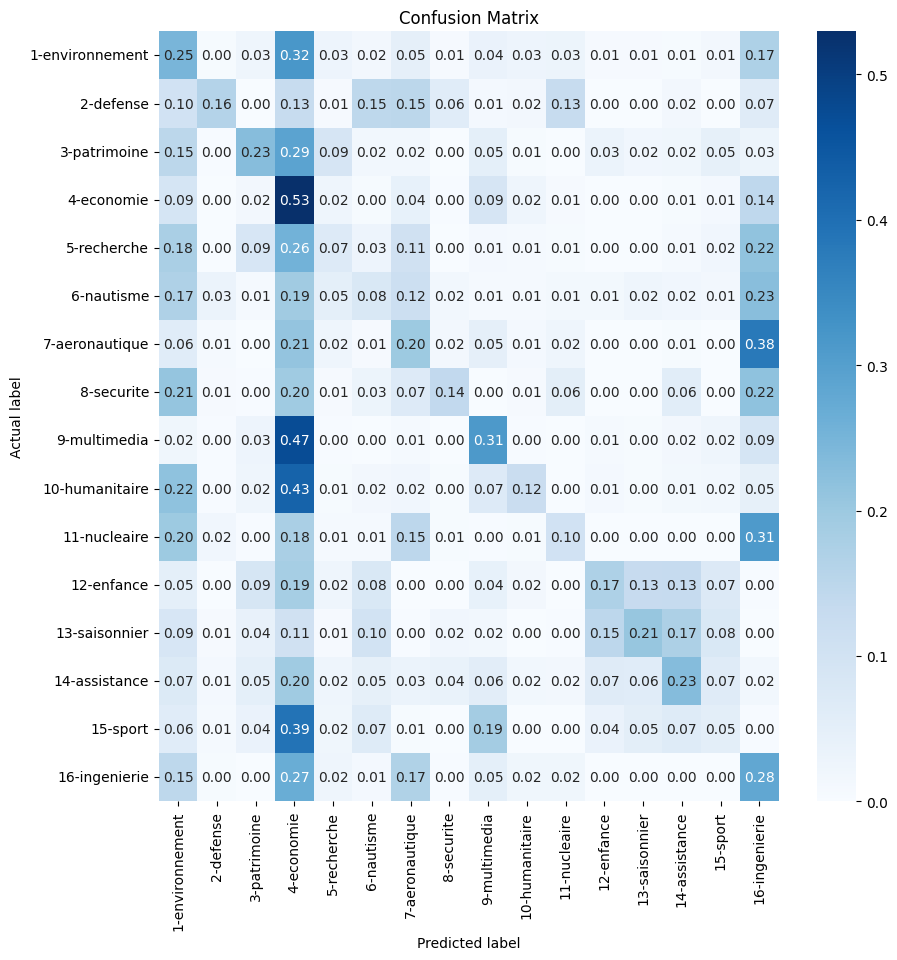

                 precision    recall  f1-score   support

1-environnement      0.235     0.248     0.241      2404
      2-defense      0.267     0.163     0.202       246
   3-patrimoine      0.315     0.228     0.265       794
     4-economie      0.321     0.530     0.400      3864
    5-recherche      0.134     0.070     0.092       975
     6-nautisme      0.189     0.079     0.112      1008
 7-aeronautique      0.212     0.200     0.206      1529
     8-securite      0.249     0.141     0.180       306
   9-multimedia      0.308     0.313     0.310      1398
 10-humanitaire      0.364     0.123     0.184      1302
   11-nucleaire      0.228     0.103     0.142       775
     12-enfance      0.221     0.173     0.194       329
  13-saisonnier      0.237     0.209     0.222       292
  14-assistance      0.303     0.231     0.262       568
       15-sport      0.125     0.055     0.076       767
  16-ingenierie      0.202     0.279     0.234      2306

       accuracy              

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=voc)
corpus = [' '.join(tokens) for tokens in train_preproc]
X_train = vectorizer.fit_transform(corpus)
print("Feature names (vocabulary):", vectorizer.get_feature_names_out())
print("TF-IDF matrix (training data):\n", X_train.toarray())

test_preproc = [preprocess_text(text) for text in test_texts]
test_corpus = [' '.join(tokens) for tokens in test_preproc]
X_test = vectorizer.transform(test_corpus)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, train_labels)

pred_labels = model.predict(X_test)

cm = confusion_matrix(test_labels, pred_labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print classification report
print(classification_report(test_labels, pred_labels, digits=3, target_names=Categories))

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

Shape of document topics matrix (TruncatedSVD): (75449, 4012)


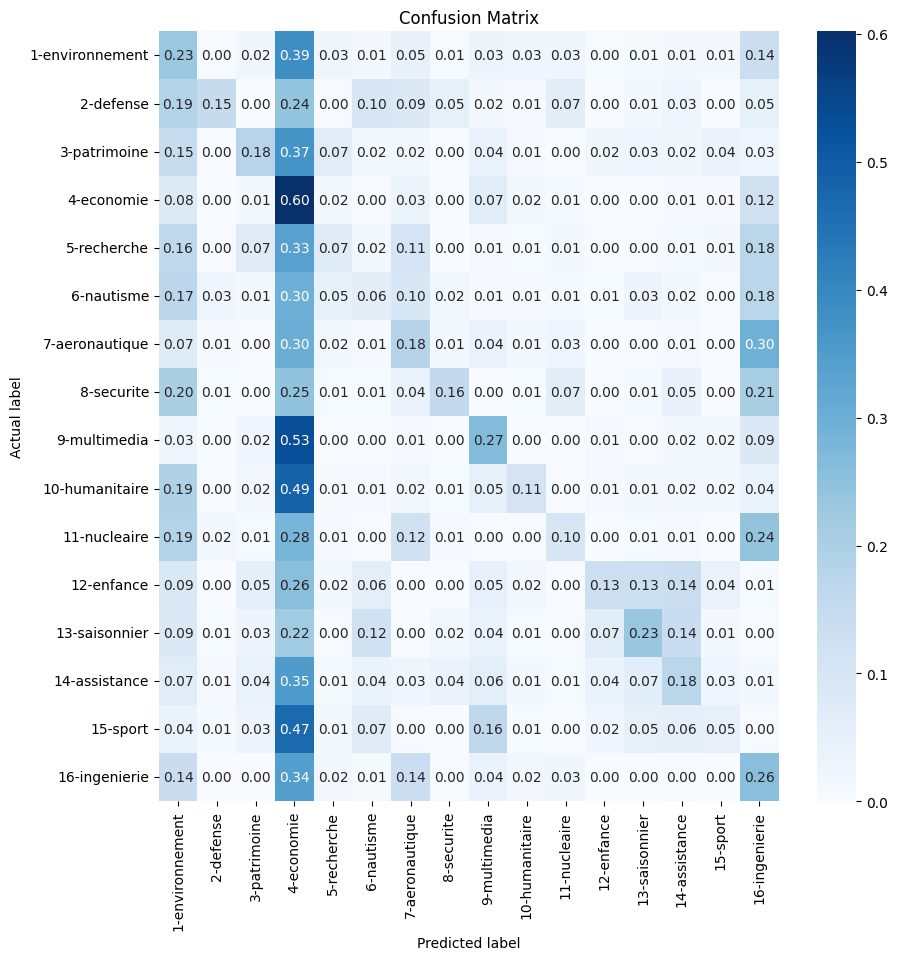

                 precision    recall  f1-score   support

1-environnement      0.230     0.232     0.231      2404
      2-defense      0.274     0.150     0.194       246
   3-patrimoine      0.296     0.180     0.224       794
     4-economie      0.295     0.602     0.396      3864
    5-recherche      0.164     0.074     0.102       975
     6-nautisme      0.182     0.064     0.095      1008
 7-aeronautique      0.227     0.182     0.202      1529
     8-securite      0.265     0.157     0.197       306
   9-multimedia      0.313     0.268     0.289      1398
 10-humanitaire      0.360     0.107     0.165      1302
   11-nucleaire      0.218     0.099     0.137       775
     12-enfance      0.254     0.134     0.175       329
  13-saisonnier      0.212     0.233     0.222       292
  14-assistance      0.236     0.176     0.202       568
       15-sport      0.165     0.051     0.078       767
  16-ingenierie      0.223     0.257     0.239      2306

       accuracy              

In [123]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
n_comps = 300

svd_model = TruncatedSVD(n_components=n_comps, random_state=42)

# Fit and transform the bag-of-words matrix (Bow) using TruncatedSVD
X_train_svd = svd_model.fit_transform(Bow)
X_test_svd = svd_model.transform(Bow_test)

# Print the shape of the reduced document representations
print("Shape of document topics matrix (TruncatedSVD):", X_train.shape)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_svd, train_labels)
pred_labels = model.predict(X_test_svd)

cm = confusion_matrix(test_labels, pred_labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print classification report
print(classification_report(test_labels, pred_labels, digits=3, target_names=Categories))

Shape of document topics matrix (TruncatedSVD): (75449, 4012)


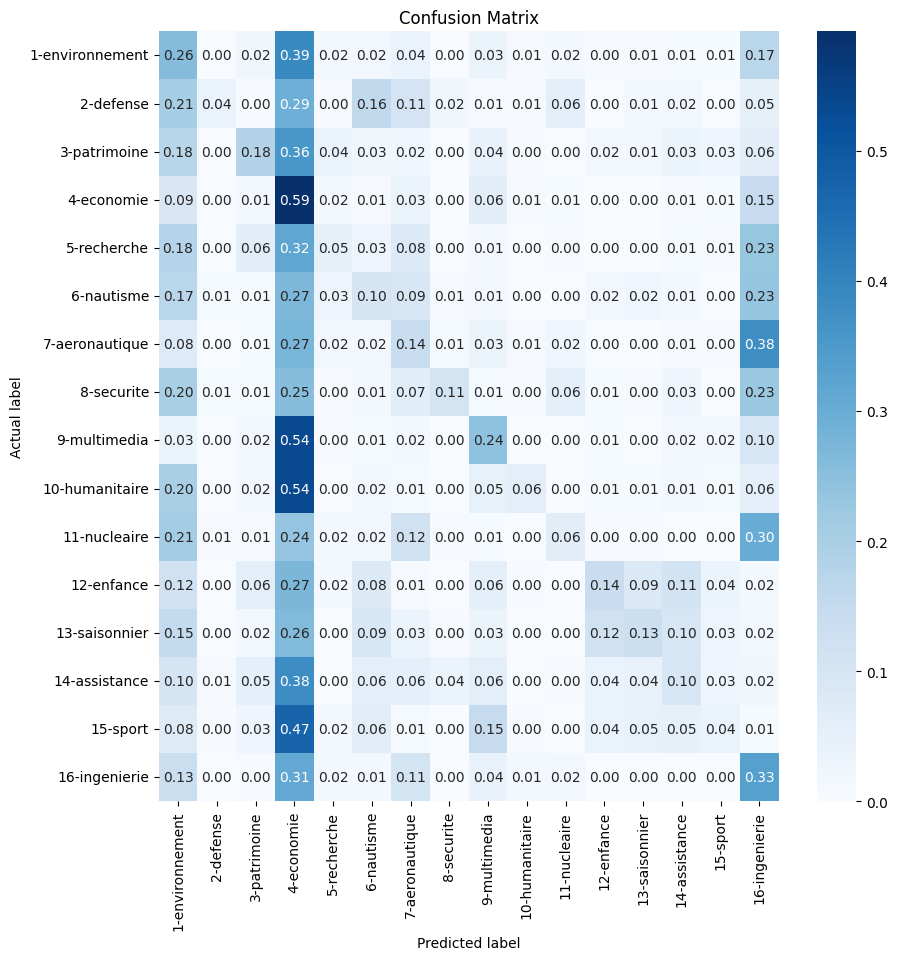

                 precision    recall  f1-score   support

1-environnement      0.232     0.257     0.244      2404
      2-defense      0.238     0.041     0.069       246
   3-patrimoine      0.295     0.181     0.225       794
     4-economie      0.295     0.592     0.394      3864
    5-recherche      0.154     0.052     0.078       975
     6-nautisme      0.204     0.103     0.137      1008
 7-aeronautique      0.195     0.141     0.163      1529
     8-securite      0.340     0.108     0.164       306
   9-multimedia      0.303     0.244     0.270      1398
 10-humanitaire      0.442     0.061     0.108      1302
   11-nucleaire      0.222     0.065     0.100       775
     12-enfance      0.208     0.137     0.165       329
  13-saisonnier      0.187     0.130     0.154       292
  14-assistance      0.167     0.097     0.123       568
       15-sport      0.168     0.040     0.065       767
  16-ingenierie      0.226     0.334     0.270      2306

       accuracy              

In [124]:
n_topics = 300
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

X_train_lda = lda_model.fit_transform(Bow)
X_test_lda = lda_model.transform(Bow_test)

# Print the shape of the reduced document representations
print("Shape of document topics matrix (TruncatedSVD):", X_train.shape)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_lda, train_labels)
pred_labels = model.predict(X_test_lda)

cm = confusion_matrix(test_labels, pred_labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print classification report
print(classification_report(test_labels, pred_labels, digits=3, target_names=Categories))

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

To decide on a suitable number of topics, we can compare the goodness-of-fit of LDA models fit with varying numbers of topics. We can evaluate the goodness-of-fit of an LDA model by calculating the perplexity of a held-out set of documents. The perplexity indicates how well the model describes a set of documents. As we're performing classification, we could use cross-validation to find the best number of topics to maximize our accuracy.

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [125]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        # sent... # not needed in the implementation below
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = [vocabulary[word] if word in vocabulary else vocabulary["UNK"] for word in sent]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(0, i-window):i]                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                M[idx, ctx_idx] += 1 / abs(i-j)
                M[ctx_idx, idx] += 1 / abs(i-j)
    return M

<div class='alert alert-block alert-info'>
            Code:</div>

In [126]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension
voc["UNK"] = len(voc) #append an unknown word to our vocabulary
coocurrence_matrix = co_occurence_matrix(train_preproc, voc)

In [127]:
n_comps = 300
svd_model = TruncatedSVD(n_components=n_comps, random_state=42)

# Fit and transform the bag-of-words matrix (Bow) using TruncatedSVD
word_embeddings_svd = svd_model.fit_transform(coocurrence_matrix)
print(word_embeddings_svd.shape)

(4013, 300)


<div class='alert alert-block alert-info'>
            Code:</div>

In [128]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = [vocabulary[word] for word in text if word in vocabulary]  # Indexes of words in the sentence obtained thanks to the vocabulary
		# Embeddings of words in the sentence, aggregated thanks to the function np_func
        sentrep = np_func(embeddings[indexes], axis=0) if indexes else np.zeros(embeddings.shape[1]) #if no words in voc found, set to zero vector
        representations.append(sentrep)
    representations = np.array(representations)
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [129]:
# Obtain document representations
X_train_embed = sentence_representations(train_preproc, voc, word_embeddings_svd)
X_test_embed = sentence_representations(test_preproc, voc, word_embeddings_svd)

print(X_train_embed.shape)

(75449, 300)


C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


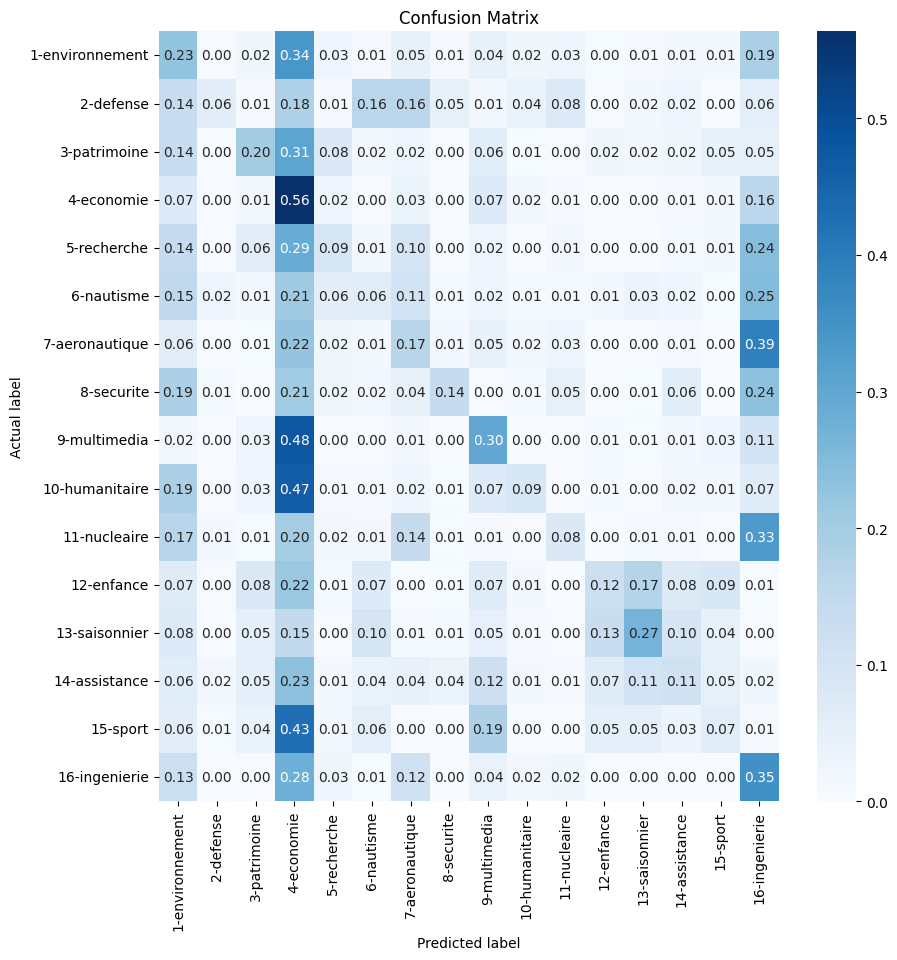

                 precision    recall  f1-score   support

1-environnement      0.246     0.228     0.236      2404
      2-defense      0.149     0.061     0.086       246
   3-patrimoine      0.304     0.203     0.243       794
     4-economie      0.319     0.564     0.407      3864
    5-recherche      0.173     0.092     0.120       975
     6-nautisme      0.189     0.064     0.096      1008
 7-aeronautique      0.209     0.167     0.185      1529
     8-securite      0.270     0.141     0.185       306
   9-multimedia      0.294     0.299     0.296      1398
 10-humanitaire      0.320     0.089     0.139      1302
   11-nucleaire      0.199     0.081     0.115       775
     12-enfance      0.170     0.125     0.144       329
  13-saisonnier      0.229     0.267     0.246       292
  14-assistance      0.193     0.113     0.142       568
       15-sport      0.162     0.065     0.093       767
  16-ingenierie      0.226     0.353     0.276      2306

       accuracy              

In [130]:
# Applying the logistic regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train_embed, train_labels)
pred_labels = model.predict(X_test_embed)

cm = confusion_matrix(test_labels, pred_labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print classification report
print(classification_report(test_labels, pred_labels, digits=3, target_names=Categories))

### Using PPMI Matrix
We can notice the accuracy improved when compared to only co-ocurrence case. This may be happening because PPMI focuses on capturing strong semantic relationships between words. It boosts the importance of meaningful word associations while suppressing less informative associations, which can enhance the quality of word representations and semantic analysis.

In [131]:
def transform_to_ppmi(cooccurrence_matrix):
    # Compute total count of all co-occurrences
    total_count = np.sum(cooccurrence_matrix)

    # Calculate marginal probabilities P(i) and P(j)
    row_sums = np.sum(cooccurrence_matrix, axis=1)
    col_sums = np.sum(cooccurrence_matrix, axis=0)
    row_probs = row_sums / (total_count + 1e-8)
    col_probs = col_sums / (total_count + 1e-8)

    # Compute conditional probabilities P(i, j)
    conditional_probs = (cooccurrence_matrix + 1e-8) / (total_count + 1e-8)

    # Compute PMI values
    pmi_matrix = np.log1p(conditional_probs / np.outer(row_probs, col_probs))

    # Compute PPMI values (apply positive transformation)
    ppmi_matrix = np.maximum(pmi_matrix, 0)

    return ppmi_matrix

(4013, 4013)


(4013, 300)
(75449, 300)


C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


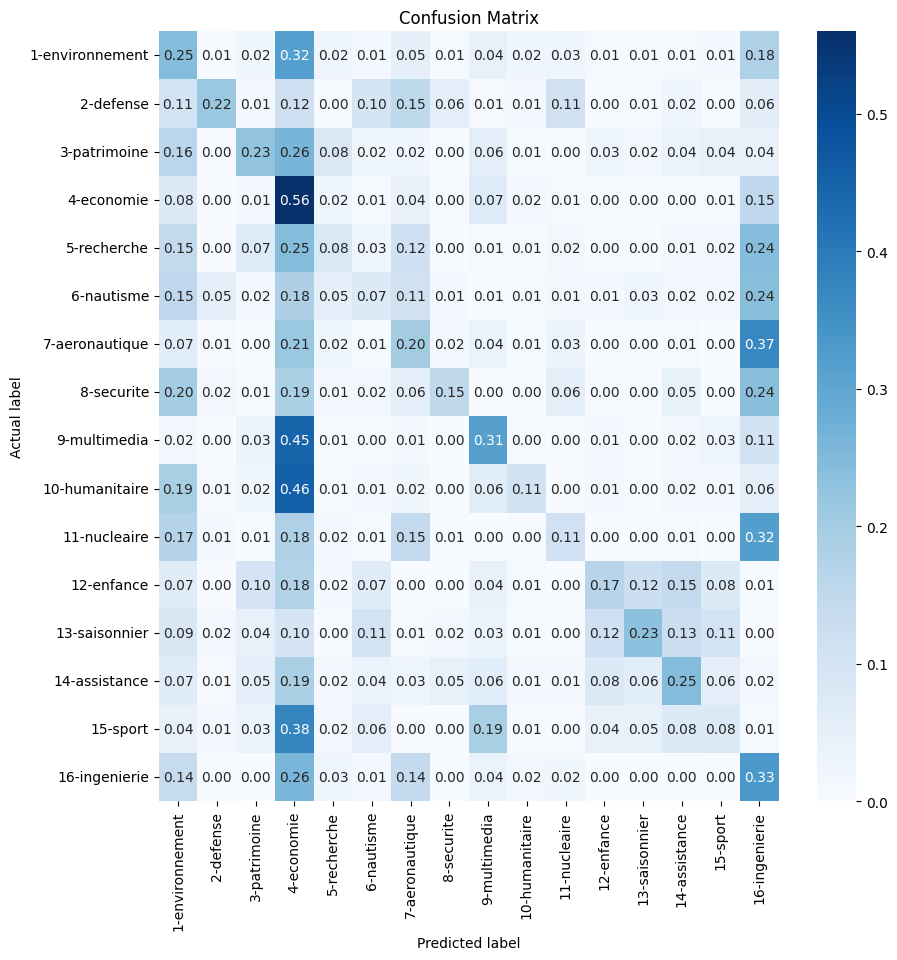

                 precision    recall  f1-score   support

1-environnement      0.254     0.247     0.250      2404
      2-defense      0.283     0.215     0.245       246
   3-patrimoine      0.311     0.225     0.262       794
     4-economie      0.337     0.560     0.421      3864
    5-recherche      0.163     0.084     0.111       975
     6-nautisme      0.188     0.074     0.107      1008
 7-aeronautique      0.221     0.203     0.211      1529
     8-securite      0.272     0.150     0.194       306
   9-multimedia      0.335     0.314     0.324      1398
 10-humanitaire      0.387     0.108     0.169      1302
   11-nucleaire      0.238     0.115     0.155       775
     12-enfance      0.208     0.167     0.185       329
  13-saisonnier      0.258     0.233     0.245       292
  14-assistance      0.297     0.246     0.269       568
       15-sport      0.174     0.081     0.110       767
  16-ingenierie      0.223     0.334     0.267      2306

       accuracy              

In [132]:
# Pipeline using PPMI matrix

ppmi_matrix = transform_to_ppmi(coocurrence_matrix)
print(ppmi_matrix.shape)

svd_model = TruncatedSVD(n_components=300, random_state=42)

# Fit and transform the co-oc matrix using TruncatedSVD
word_embeddings_svd = svd_model.fit_transform(ppmi_matrix)
print(word_embeddings_svd.shape)

X_train_embed = sentence_representations(train_preproc, voc, word_embeddings_svd)
X_test_embed = sentence_representations(test_preproc, voc, word_embeddings_svd)
print(X_train_embed.shape)

# Applying the logistic regression classifier
model = LogisticRegression(max_iter=1000)
model.fit(X_train_embed, train_labels)
pred_labels = model.predict(X_test_embed)

cm = confusion_matrix(test_labels, pred_labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print classification report
print(classification_report(test_labels, pred_labels, digits=3, target_names=Categories))

## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [133]:
from gensim.models import Word2Vec

In [134]:
word_counts = np.sum(Bow.toarray(), axis=0)
print(word_counts.shape)

model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))

word_counts_dict = {word: count for word, count in zip(voc, word_counts)}
model.build_vocab_from_freq(word_counts_dict)
print(word_counts_dict)

(4012,)
{'largag': 2, 'for': 12, 'fao': 7, 'extrus': 7, 'doublag': 1, 'fiabl': 42, 'jeu': 44, 'écoul': 8, 'région': 11, 'cffp': 7, 'joailler': 12, 'marketing': 2365, 'avanc': 374, 'erp': 6, 'qsa': 10, 'mur': 1, 'adhérent': 3, 'sarii': 10, 'genes': 4, 'fuseau': 2, 'epmi': 8, 'prêt': 2, 'dinander': 2, 'méthodolog': 7, 'pac': 34, 'climat': 571, 'maison': 12, 'chebap': 5, 'itech': 19, 'consult': 121, 'interoper': 5, 'bioactif': 4, 'pao': 1, 'titrag': 1, 'stockag': 48, 'deg': 11, 'fib': 1, 'regl': 1, 'envelopp': 17, 'gen': 5002, 'exécu': 7, 'lexicolog': 5, 'cart': 27, 'sélect': 1, 'patron': 5, 'informaticien': 16, 'gard': 40, 'chaux': 1, 'universität': 8, 'i': 0, 'bio': 265, 'biosant': 12, 'utilis': 3, 'ere': 14, 'nier': 18, 'strateg': 1251, 'afriqu': 10, 'allemand': 227, 'ambianc': 19, 'grignon': 11, 'sdo': 3, 'serrurer': 3, 'cours': 22, 'calm': 6, 'anglais': 311, 'centr': 350, 'eess': 2, 'vendeur': 95, 'poêli': 1, 'acquisit': 16, 'mip': 10, 'gst': 12, 'vinicol': 30, 'continus': 28, 'ris':

<div class='alert alert-block alert-info'>
            Code:</div>

In [135]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = train_preproc
len(preprocessed_corpus)

75449

In [136]:
model.train(preprocessed_corpus, total_examples=len(preprocessed_corpus), epochs=30, report_delay=1)

(11002864, 17236920)

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [137]:
def sentence_representations(sentences, model, np_func=np.mean):
    "Adapted to work with keyed vectors from Word2Vec"
    representations = []
    for sentence in sentences:
        word_vectors = [model.wv[word] for word in sentence if word in model.wv]
        if word_vectors:
            sentence_representation = np_func(word_vectors, axis=0)
            representations.append(sentence_representation)
        else:
            # If no word vectors found for the sentence, use zero vector
            representations.append(np.zeros(model.vector_size))
    return np.array(representations)

In [138]:
X_train_vectorized = sentence_representations(preprocessed_corpus, model)
X_test_vectorized = sentence_representations(test_preproc, model)
print("Shape of document representations:", X_train_vectorized.shape)
#print(doc_representations[1])

Shape of document representations: (75449, 300)


C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


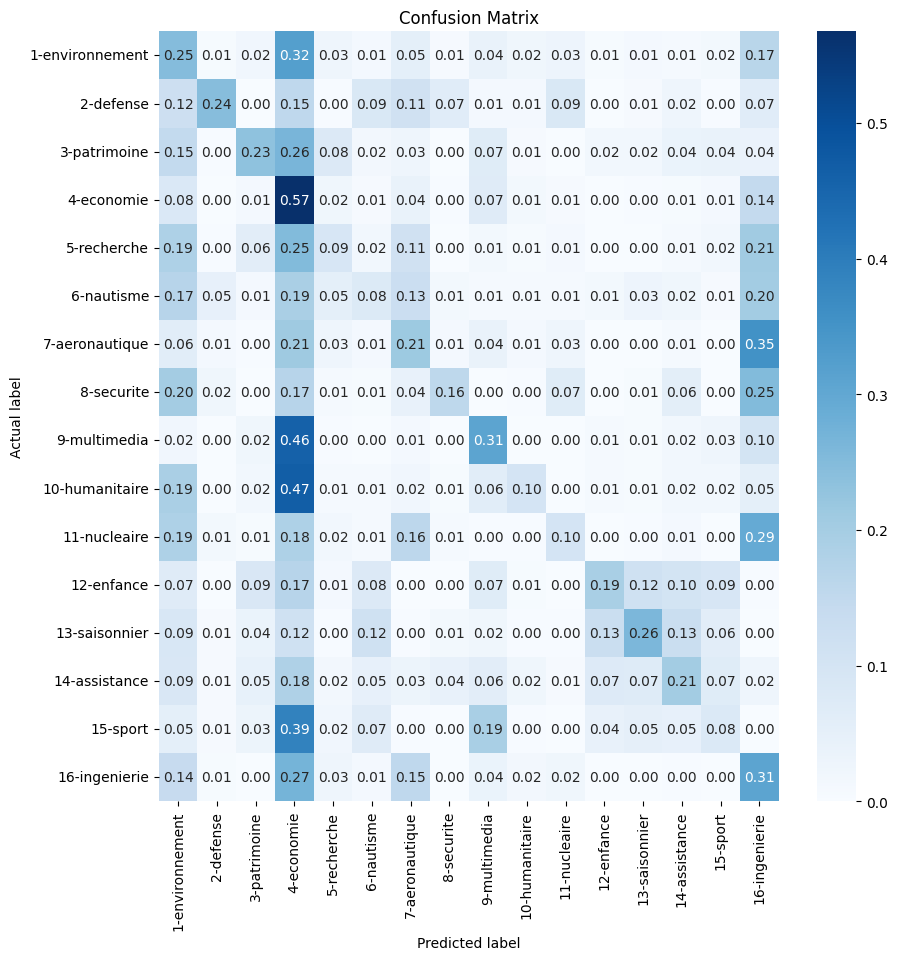

                 precision    recall  f1-score   support

1-environnement      0.242     0.248     0.245      2404
      2-defense      0.309     0.244     0.273       246
   3-patrimoine      0.361     0.234     0.284       794
     4-economie      0.335     0.568     0.421      3864
    5-recherche      0.169     0.092     0.119       975
     6-nautisme      0.191     0.076     0.109      1008
 7-aeronautique      0.225     0.215     0.219      1529
     8-securite      0.267     0.157     0.198       306
   9-multimedia      0.325     0.308     0.316      1398
 10-humanitaire      0.377     0.101     0.160      1302
   11-nucleaire      0.227     0.101     0.139       775
     12-enfance      0.249     0.195     0.218       329
  13-saisonnier      0.250     0.260     0.255       292
  14-assistance      0.268     0.206     0.233       568
       15-sport      0.174     0.081     0.110       767
  16-ingenierie      0.223     0.310     0.260      2306

       accuracy              

In [139]:
LogReg = LogisticRegression(max_iter=1000)
LogReg.fit(X_train_vectorized, train_labels)
pred_labels = LogReg.predict(X_test_vectorized)

cm = confusion_matrix(test_labels, pred_labels, normalize='true')

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=Categories, yticklabels=Categories)
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Generate and print classification report
print(classification_report(test_labels, pred_labels, digits=3, target_names=Categories))

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 

The big issue is that the train dataset is imbalanced (as can be seen below in the distribution of classes in train labels) and logistic regression will pay more attention to specific classses by assigning higher weights to them during training, biasing the results towards the most frequent class. Indeed we noticed looking at the results that the most frequent class (4) has better accuracy than others and looking at confusion matrix we see that the model is also incorrectly assigning the class 4 to the sentences more frequently than others.
To solve this problem we could implement resampling techniques like oversampling the minority class or undersampling the majority class to balance the dataset. We can use libraries like imbalanced-learn in Python to apply these techniques. \
Another solution is to define a weighted loss function to penalize more the less frequent classes missclassifications.

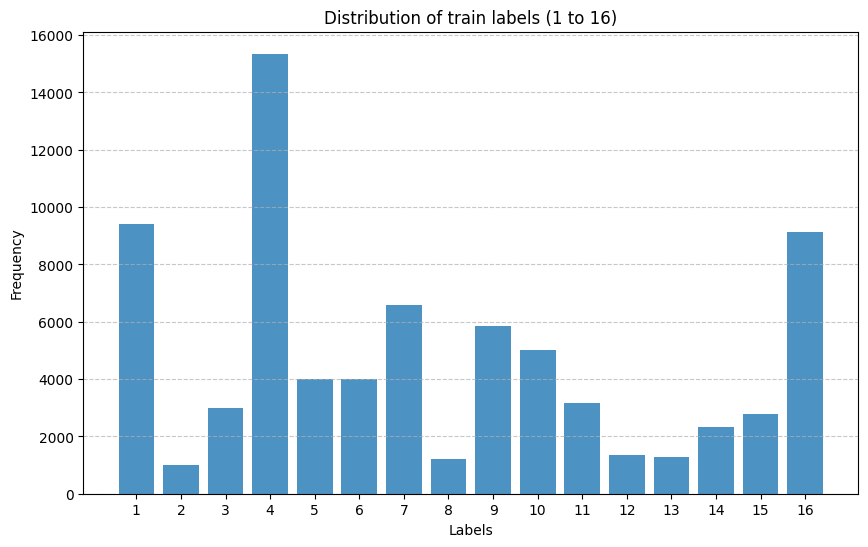

In [141]:
counters = np.zeros(16)

for i in range(len(train_labels)):
    counters[train_labels[i]-1] += 1
    
# Define the labels corresponding to indices 1 to 16
labels = np.arange(1, 17)  # Labels from 1 to 16

# Plotting the distribution as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, counters, align='center', alpha=0.8)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of train labels (1 to 16)')
plt.xticks(labels)  # Set x-ticks to show all labels from 1 to 16
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()